## Preparation

In [3]:
# Imports
import json
import torch
import numpy as np
import pandas as pd
from scipy.stats import entropy
import matplotlib.pyplot as plt

In [4]:
# Load files
def load_probs(path):
    with open(path, "r") as _file:
        probs = json.load(_file)
    return probs

## Subset Training Dynamics

In [13]:
base_path = "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds_snli/600_it_train_10_step/runs/2022-05-15/12-08-12/"
batch_size = 32
recording_rate = 10

In [14]:
import glob
# train_files = glob.glob(base_path + "train_predictions/*.npy")
val_files = glob.glob(base_path + "snli_val_predictions/*.npy")
num_recordings = len(val_files)

# Sanity check: order of files must be the "natural order"
val_files

['/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds_snli/600_it_train_10_step/runs/2022-05-15/12-08-12/snli_val_predictions/0.npy',
 '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds_snli/600_it_train_10_step/runs/2022-05-15/12-08-12/snli_val_predictions/1.npy',
 '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds_snli/600_it_train_10_step/runs/2022-05-15/12-08-12/snli_val_predictions/2.npy',
 '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds_snli/600_it_train_10_step/runs/2022-05-15/12-08-12/snli_val_predictions/3.npy',
 '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds_snli/600_it_train_10_step/runs/2022-05-15/12-08-12/snli_val_predictions/4.npy',
 '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds_snli/600_it_train_10_step/runs/2022-05-15/12-08-12/snli_val_predictions/5.npy',
 '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds_sn

In [15]:
# train_preds = [np.load(_file) for _file in train_files]
val_preds = [np.load(_file) for _file in val_files]

In [16]:
steps = [i * batch_size * recording_rate for i in range(num_recordings)]

## Negation Subset

In [19]:
with open("/home/meissner/shortcut-pruning/data/subsets/snli_negation_indices.json", "r") as _file:
    indices = json.loads(_file.read())

In [20]:
# train_conts = np.array(indices["train_conts"])
# train_ents = np.array(indices["train_ents"])
val_conts = np.array(indices["val_conts"])
val_ents = np.array(indices["val_ents"])

In [39]:
# train_cont_levels = [preds[train_conts, 2].mean() for preds in train_preds]
# train_ent_levels = [preds[train_ents, 0].mean() for preds in train_preds]
val_cont_set_cont_levels = [preds[val_conts, 2].mean() for preds in val_preds]
val_ent_set_ent_levels = [preds[val_ents, 0].mean() for preds in val_preds]
val_cont_set_ent_levels = [preds[val_conts, 0].mean() for preds in val_preds]
val_ent_set_cont_levels = [preds[val_ents, 2].mean() for preds in val_preds]

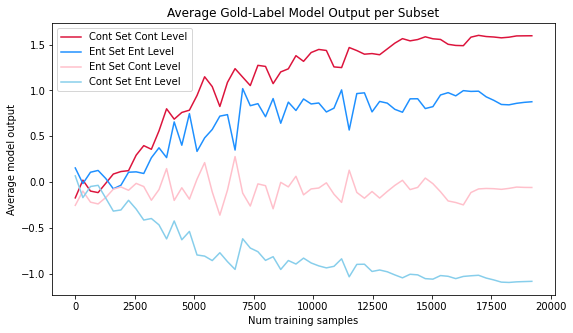

In [40]:
plt.plot(steps, val_cont_set_cont_levels, label="Cont Set Cont Level", color="crimson")
plt.plot(steps, val_ent_set_ent_levels, label="Ent Set Ent Level", color="dodgerblue")
plt.plot(steps, val_ent_set_cont_levels, label="Ent Set Cont Level", color="pink")
plt.plot(steps, val_cont_set_ent_levels, label="Cont Set Ent Level", color="skyblue")
plt.xlabel("Num training samples")
plt.ylabel("Average model output")
plt.title("Average Gold-Label Model Output per Subset")
plt.legend()

In [24]:
# train_dfs = [pd.DataFrame(array) for array in train_preds]
val_dfs = [pd.DataFrame(array) for array in val_preds]

In [25]:
# for df in train_dfs:
#     df.loc[train_conts, "label"] = "contradiction"
#     df.loc[train_conts, "gold_pred"] = df[2]
#     df.loc[train_ents, "label"] = "entailment"
#     df.loc[train_ents, "gold_pred"] = df[0]
#     df.drop([0, 1, 2], axis=1, inplace=True)
#     df.dropna(inplace=True)
    
for df in val_dfs:
    df.loc[val_conts, "label"] = "contradiction"
    df.loc[val_conts, "gold_pred"] = df[2]
    df.loc[val_ents, "label"] = "entailment"
    df.loc[val_ents, "gold_pred"] = df[0]
    df.drop([0, 1, 2], axis=1, inplace=True)
    df.dropna(inplace=True)

In [36]:
percent = 0.1
# negation_train_count = len(train_conts) + len(train_ents)
negation_val_count = len(val_conts) + len(val_ents)
negation_val_count

316

In [37]:
# train_worst = [df.sort_values("gold_pred", ascending=True).head(int(percent * negation_train_count)).groupby("label").count() for df in train_dfs]
val_worst = [df.sort_values("gold_pred", ascending=True).head(int(percent * negation_val_count)).groupby("label").count() for df in val_dfs]

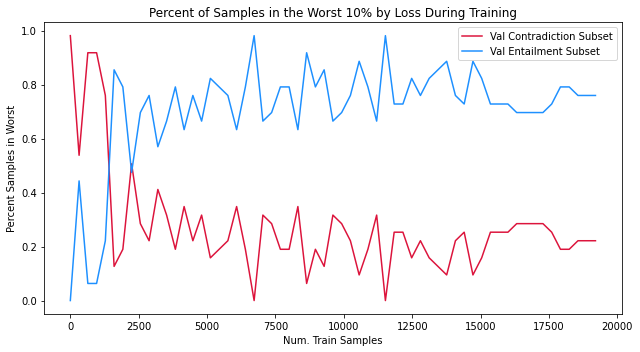

In [38]:
plt.rcParams["figure.figsize"] = (9,5)
# plt.plot(steps, [series.loc['contradiction'] / (percent * negation_train_count) if 'contradiction' in series.index else 0 for series in train_worst], label="Train Contradiction Subset", color="pink")
# plt.plot(steps, [series.loc['entailment'] / (percent * negation_train_count) if 'entailment' in series.index else 0 for series in train_worst], label="Train Entailment Subset", color="skyblue")
plt.plot(steps, [series.loc['contradiction'] / (percent * negation_val_count) if 'contradiction' in series.index else 0 for series in val_worst], label="Val Contradiction Subset", color="crimson")
plt.plot(steps, [series.loc['entailment'] / (percent * negation_val_count) if 'entailment' in series.index else 0 for series in val_worst], label="Val Entailment Subset", color="dodgerblue")
plt.xlabel("Num. Train Samples")
plt.ylabel("Percent Samples in Worst")
plt.title("Percent of Samples in the Worst 10% by Loss During Training")
plt.legend()
plt.tight_layout()
plt.show()

## Overlap Subsets

In [44]:
with open("/home/meissner/shortcut-pruning/data/subsets/snli_lex_overlap_indices.json", "r") as _file:
    indices = json.loads(_file.read())

In [45]:
# train_conts = np.array(indices["train_conts"])
# train_ents = np.array(indices["train_ents"])
val_conts = np.array(indices["val_conts"])
val_ents = np.array(indices["val_ents"])

In [46]:
# train_cont_levels = [preds[train_conts, 2].mean() for preds in train_preds]
# train_ent_levels = [preds[train_ents, 0].mean() for preds in train_preds]
val_cont_set_cont_levels = [preds[val_conts, 2].mean() for preds in val_preds]
val_ent_set_ent_levels = [preds[val_ents, 0].mean() for preds in val_preds]
val_cont_set_ent_levels = [preds[val_conts, 0].mean() for preds in val_preds]
val_ent_set_cont_levels = [preds[val_ents, 2].mean() for preds in val_preds]

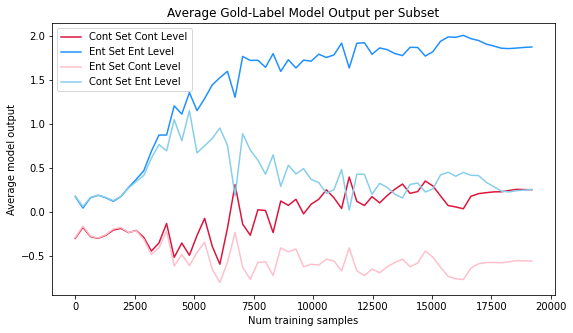

In [47]:
plt.plot(steps, val_cont_set_cont_levels, label="Cont Set Cont Level", color="crimson")
plt.plot(steps, val_ent_set_ent_levels, label="Ent Set Ent Level", color="dodgerblue")
plt.plot(steps, val_ent_set_cont_levels, label="Ent Set Cont Level", color="pink")
plt.plot(steps, val_cont_set_ent_levels, label="Cont Set Ent Level", color="skyblue")
plt.xlabel("Num training samples")
plt.ylabel("Average model output")
plt.title("Average Gold-Label Model Output per Subset")
plt.legend()

In [48]:
# train_dfs = [pd.DataFrame(array) for array in train_preds]
val_dfs = [pd.DataFrame(array) for array in val_preds]

In [49]:
# for df in train_dfs:
#     df.loc[train_conts, "label"] = "contradiction"
#     df.loc[train_conts, "gold_pred"] = df[2]
#     df.loc[train_ents, "label"] = "entailment"
#     df.loc[train_ents, "gold_pred"] = df[0]
#     df.drop([0, 1, 2], axis=1, inplace=True)
#     df.dropna(inplace=True)
    
for df in val_dfs:
    df.loc[val_conts, "label"] = "contradiction"
    df.loc[val_conts, "gold_pred"] = df[2]
    df.loc[val_ents, "label"] = "entailment"
    df.loc[val_ents, "gold_pred"] = df[0]
    df.drop([0, 1, 2], axis=1, inplace=True)
    df.dropna(inplace=True)

In [50]:
percent = 0.1
# negation_train_count = len(train_conts) + len(train_ents)
negation_val_count = len(val_conts) + len(val_ents)
negation_val_count

715

In [51]:
# train_worst = [df.sort_values("gold_pred", ascending=True).head(int(percent * negation_train_count)).groupby("label").count() for df in train_dfs]
val_worst = [df.sort_values("gold_pred", ascending=True).head(int(percent * negation_val_count)).groupby("label").count() for df in val_dfs]

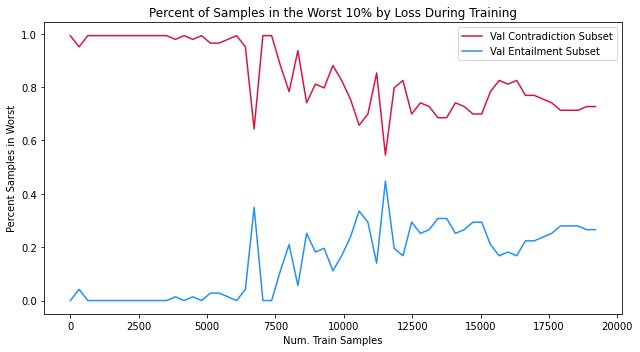

In [52]:
plt.rcParams["figure.figsize"] = (9,5)
# plt.plot(steps, [series.loc['contradiction'] / (percent * negation_train_count) if 'contradiction' in series.index else 0 for series in train_worst], label="Train Contradiction Subset", color="pink")
# plt.plot(steps, [series.loc['entailment'] / (percent * negation_train_count) if 'entailment' in series.index else 0 for series in train_worst], label="Train Entailment Subset", color="skyblue")
plt.plot(steps, [series.loc['contradiction'] / (percent * negation_val_count) if 'contradiction' in series.index else 0 for series in val_worst], label="Val Contradiction Subset", color="crimson")
plt.plot(steps, [series.loc['entailment'] / (percent * negation_val_count) if 'entailment' in series.index else 0 for series in val_worst], label="Val Entailment Subset", color="dodgerblue")
plt.xlabel("Num. Train Samples")
plt.ylabel("Percent Samples in Worst")
plt.title("Percent of Samples in the Worst 10% by Loss During Training")
plt.legend()
plt.tight_layout()
plt.show()